In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pickle
import imageio
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, utils
from torch.autograd import Variable
from random import random

%matplotlib inline

In [2]:
IMG_SIZE = 160
Z_DIMENSION = 32
BATCH_SIZE = 36
NUM_CHANNELS = 3
NUM_ITERATIONS = 50
FRAME_SKIP = 4

In [3]:
imageio.plugins.ffmpeg.download()

In [4]:
class DoomFrameDataset(torch.utils.data.Dataset):
    def __init__(self, video_location, transform=None):
        """
        video_location (string): Path to the video file
        transform (function, optional): Transforms to apply
        """
        self.video_reader = imageio.get_reader(video_location,  'ffmpeg')
        self.frames = [PIL.Image.fromarray(self.video_reader.get_data(idx)) 
                       for idx in range(len(self.video_reader)) 
                       if idx % FRAME_SKIP == 0]
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        image = self.frames[idx]

        if self.transform:
            image = self.transform(image)

        return image

img_trans = transforms.Compose([transforms.Resize(IMG_SIZE),
                                transforms.CenterCrop(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

doom_data = DoomFrameDataset("data/doom_gameplay.mp4", img_trans)

doom_loader = torch.utils.data.DataLoader(doom_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [3]:
class DoomGenerator(nn.Module):
    def __init__(self, hidden_units = 128):
        super(DoomGenerator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIMENSION, hidden_units*32, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(hidden_units*32)
        self.deconv2 = nn.ConvTranspose2d(hidden_units*32, hidden_units*16, 4, 1, 0)
        self.deconv2_bn = nn.BatchNorm2d(hidden_units*16)
        self.deconv3 = nn.ConvTranspose2d(hidden_units*16, hidden_units*8, 4, 1, 0)
        self.deconv3_bn = nn.BatchNorm2d(hidden_units*8)
        self.deconv4 = nn.ConvTranspose2d(hidden_units*8, hidden_units*4, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(hidden_units*4)
        self.deconv5 = nn.ConvTranspose2d(hidden_units*4, hidden_units*2, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(hidden_units*2)
        self.deconv6 = nn.ConvTranspose2d(hidden_units*2, hidden_units, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(hidden_units)
        self.deconv7 = nn.ConvTranspose2d(hidden_units, NUM_CHANNELS, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, z_data):
        x = F.relu(self.deconv1_bn(self.deconv1(z_data)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.relu(self.deconv5_bn(self.deconv5(x)))
        x = F.relu(self.deconv6_bn(self.deconv6(x)))
        x = F.tanh(self.deconv7(x))

        return x

doom_generator = DoomGenerator()

In [6]:
class DoomDiscriminator(nn.Module):
    def __init__(self, hidden_units=128):
        super(DoomDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(NUM_CHANNELS, hidden_units, 4, 2, 1)
        self.conv2 = nn.Conv2d(hidden_units, hidden_units*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(hidden_units*2)
        self.conv3 = nn.Conv2d(hidden_units*2, hidden_units*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(hidden_units*4)
        self.conv4 = nn.Conv2d(hidden_units*4, hidden_units*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(hidden_units*8)
        self.conv5 = nn.Conv2d(hidden_units*8, hidden_units*16, 4, 1, 0)
        self.conv5_bn = nn.BatchNorm2d(hidden_units*16)
        self.conv6 = nn.Conv2d(hidden_units*16, hidden_units*32, 4, 1, 0)
        self.conv6_bn = nn.BatchNorm2d(hidden_units*32)
        self.conv7 = nn.Conv2d(hidden_units*32, 1, 4, 1, 0)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, image):
        x = F.leaky_relu(self.conv1(image), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        x = F.leaky_relu(self.conv6_bn(self.conv6(x)), 0.2)
        x = F.sigmoid(self.conv7(x))

        return x

doom_discriminator = DoomDiscriminator()

In [7]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [7]:
#doom_discriminator.weight_init(0, .02)
#doom_discriminator.cuda()

#doom_generator.weight_init(0, .02)
#doom_generator.cuda()

In [21]:
doom_generator.load_state_dict(torch.load('gen_after_40.pth', map_location = lambda storage, loc: storage))
doom_generator.eval()
#doom_discriminator.load_state_dict(torch.load('gan_files/disc_latest.pth'))

DoomGenerator(
  (deconv1): ConvTranspose2d(32, 4096, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True)
  (deconv2): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(1, 1))
  (deconv2_bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True)
  (deconv3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv3_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (deconv4): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (deconv5): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (deconv6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv6_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (deconv7): ConvTranspose2d(128, 3, kernel_size=(4, 4), st

In [ ]:
noise = torch.FloatTensor(BATCH_SIZE, Z_DIMENSION, 1, 1).cuda()
fixed_noise = Variable(torch.FloatTensor(BATCH_SIZE, Z_DIMENSION, 1, 1).normal_(0, 1)).cuda()

disc_opt = optim.Adam(doom_discriminator.parameters(), lr=.0001, betas=(.5, 0.999))
gen_opt = optim.Adam(doom_generator.parameters(), lr=.0001, betas=(.5, 0.999))

binary_cross_entropy_loss = nn.BCELoss()

disc_scheduler = optim.lr_scheduler.StepLR(disc_opt, 10, .25)
gen_scheduler = optim.lr_scheduler.StepLR(gen_opt, 10, .25)

added_noise = .1

In [ ]:
fake = doom_generator(fixed_noise)
utils.save_image(fake.data,
        'gan_files/fake_frames_before_training.png',
        normalize = True, nrow = 6)

for epoch in range(1, NUM_ITERATIONS + 1):
    disc_scheduler.step()
    gen_scheduler.step()
    for repeat in range(1, FRAME_SKIP + 1):
        for i, data in enumerate(doom_loader, start = 1):

            if i == 1 and epoch == 1:
                utils.save_image(data, 'gan_files/real_frames.png', normalize = True, nrow = 6)


            real_label = Variable(torch.FloatTensor(data.size(0)).uniform_(0.7, 1.2)).cuda()
            fake_label = Variable(torch.FloatTensor(noise.size(0)).uniform_(0.0, 0.3)).cuda()

            doom_discriminator.zero_grad()
            noisy_input = data + torch.FloatTensor(*data.size()).normal_(0, added_noise * .95 ** epoch)
            inputv = Variable(noisy_input).cuda()

            real_output = doom_discriminator(inputv)


            # train with fake
            noise.normal_(0, 1)
            noisev = Variable(noise).cuda()
            fake = doom_generator(noisev)
            noisy_fake = fake.data + torch.FloatTensor(*fake.size()).normal_(0, added_noise * .95 ** epoch).cuda()
            fake_output = doom_discriminator(Variable(noisy_fake).cuda())

            if random() < 0.01:    
                disc_real_loss = binary_cross_entropy_loss(real_output.squeeze(), Variable(real_label.data.uniform_(0.0, 0.3)).cuda())
                disc_fake_loss = binary_cross_entropy_loss(fake_output.squeeze(), Variable(fake_label.data.uniform_(0.7, 1.2)).cuda())
            else:
                disc_real_loss = binary_cross_entropy_loss(real_output.squeeze(), real_label)
                disc_fake_loss = binary_cross_entropy_loss(fake_output.squeeze(), fake_label)

            disc_real_loss.backward()
            disc_fake_loss.backward()

            disc_loss = disc_real_loss + disc_fake_loss

            disc_opt.step()



            doom_generator.zero_grad()
            output = doom_discriminator(fake)
            real_label = Variable(torch.FloatTensor(output.size(0)).fill_(1)).cuda()

            gen_loss = binary_cross_entropy_loss(output.squeeze(), real_label)
            gen_loss.backward()
            gen_opt.step()


        print(f"""[{epoch}/{NUM_ITERATIONS}] :: [{repeat}/{FRAME_SKIP}]
        Disc_Real_Conf: {real_output.data.mean()}  Disc_Fake_Conf: {fake_output.data.mean()}""")

    fake = doom_generator(fixed_noise)
    utils.save_image(fake.data,
            f'gan_files/fake_frames_after_epoch_{epoch}.png',
            normalize = True, nrow = 6)

    # do checkpointing
    torch.save(doom_generator.state_dict(), f'gan_files/gen_after_{epoch}.pth')
    torch.save(doom_discriminator.state_dict(), f'gan_files/disc_after_{epoch}.pth')

[1/50] :: [1/4]
        Disc_Real_Conf: 0.9242219924926758  Disc_Fake_Conf: 0.12687423825263977
[1/50] :: [2/4]
        Disc_Real_Conf: 0.7546641230583191  Disc_Fake_Conf: 0.2026236653327942
[1/50] :: [3/4]
        Disc_Real_Conf: 0.9752607345581055  Disc_Fake_Conf: 0.5885451436042786
[1/50] :: [4/4]
        Disc_Real_Conf: 0.7569852471351624  Disc_Fake_Conf: 0.4100164473056793
[2/50] :: [1/4]
        Disc_Real_Conf: 0.7632147669792175  Disc_Fake_Conf: 0.396855890750885
[2/50] :: [2/4]
        Disc_Real_Conf: 0.9135600924491882  Disc_Fake_Conf: 0.688130795955658
[2/50] :: [3/4]
        Disc_Real_Conf: 0.8069918751716614  Disc_Fake_Conf: 0.3609880208969116
[2/50] :: [4/4]
        Disc_Real_Conf: 0.43854662775993347  Disc_Fake_Conf: 0.252834677696228
[3/50] :: [1/4]
        Disc_Real_Conf: 0.7628121972084045  Disc_Fake_Conf: 0.2290276437997818
[3/50] :: [2/4]
        Disc_Real_Conf: 0.5037022829055786  Disc_Fake_Conf: 0.42342609167099
[3/50] :: [3/4]
        Disc_Real_Conf: 0.76528573036

In [13]:
arr.max(), arr.min()

(3.250998155485923, -3.177563071022942)

In [15]:
output.max(), output.min()

(Variable containing:
  0.9321
 [torch.FloatTensor of size 1], Variable containing:
 -1.0000
 [torch.FloatTensor of size 1])

In [29]:
bloody_screen = arr[10]
np.sum(bloody_screen ** 2)

32.70735941762871

In [31]:
normal_screen = arr[13]
np.sum(normal_screen ** 2)

38.617068081173755

In [38]:
bloody_screen = bloody_screen.squeeze()
normal_screen = normal_screen.squeeze()

In [32]:
#From https://github.com/dribnet/plat/blob/master/plat/interpolate.py
def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif np.allclose(low, high):
        return low
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

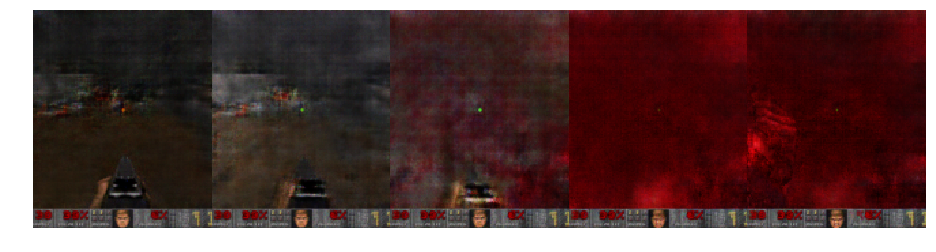

In [43]:
fig, axs = plt.subplots(1, 5, figsize = (16, 4), sharey = True)
fig.subplots_adjust(hspace = 0, wspace = 0)
for i, ax in enumerate(axs.flatten()):
    val = i / 4
    interpolated = slerp(val, normal_screen, bloody_screen)[None, ..., None, None]
    output = doom_generator(Variable(torch.Tensor(interpolated)))
    ax.axis('off')
    ax.imshow(output.squeeze().data.numpy().transpose(1, 2, 0) * .5 + .5)
fig.savefig("gan_files/interpolate.png")

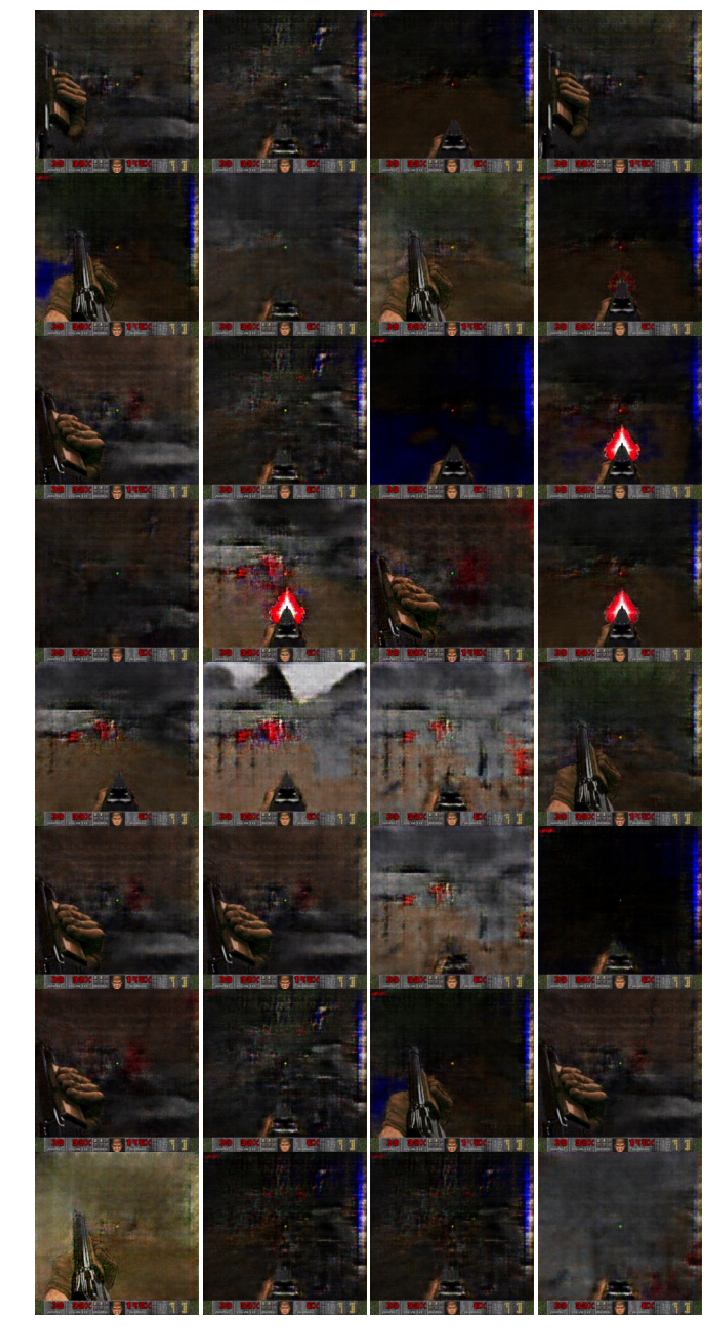

In [41]:
fig, axs = plt.subplots(8, 4, figsize = (12, 24), sharex = True, sharey = True)
fig.subplots_adjust(hspace=0, wspace=0)
arr = np.random.normal(size = (8*4, Z_DIMENSION, 1, 1))
output = doom_generator(Variable(torch.Tensor(arr)))

for ax, dim in zip(axs.flatten(), range(Z_DIMENSION)):
    ax.axis('off')
    ax.imshow(output.squeeze().data.numpy()[dim].transpose(1, 2, 0) * .5 + .5)


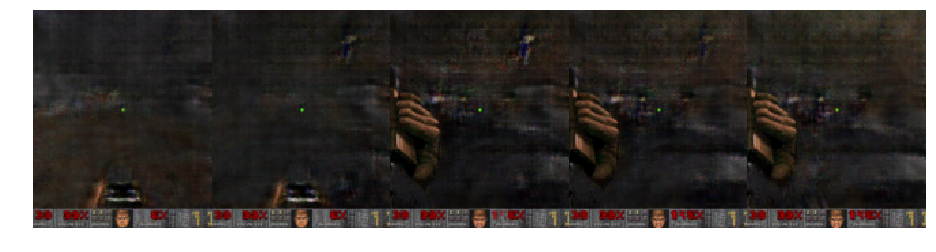

In [42]:
not_shooting = arr[5].squeeze()
shooting = arr[0].squeeze()

fig, axs = plt.subplots(1, 5, figsize = (16, 4), sharey = True)
fig.subplots_adjust(hspace = 0, wspace = 0)
for i, ax in enumerate(axs.flatten()):
    val = i / 4
    interpolated = slerp(val, not_shooting, shooting)[None, ..., None, None]
    output = doom_generator(Variable(torch.Tensor(interpolated)))
    ax.axis('off')
    ax.imshow(output.squeeze().data.numpy().transpose(1, 2, 0) * .5 + .5)